In [64]:
import openmc
from pathlib import Path
import sys
import os 
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))
from parameters.parameters_materials import AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, CDTE_MATERIAL

material = openmc.Materials([AIR_MATERIAL, CDTE_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL])


from src.utils.pre_processing.pre_processing import plot_geometry, parallelepiped


In [65]:
material.export_to_xml()


In [ ]:

# === Paramètres géométriques ===
pixel_size = 0.8 * 0.1      # 0.8 mm → cm
pixel_thickness = 2.0 * 0.1 # 2 mm → cm (en x)
frame_thickness = 1.0 * 0.1 # 1 mm → cm

n_y = 16  # Nombre de pixels selon y
n_z = 16  # Nombre de pixels selon z

# Matériaux
cdte_material = CDTE_MATERIAL
air_material = AIR_MATERIAL

# === Dimensions de la matrice ===
matrix_width_y = n_y * pixel_size
matrix_width_z = n_z * pixel_size
total_width_y = matrix_width_y + 2 * frame_thickness
total_width_z = matrix_width_z + 2 * frame_thickness

# === Plans de délimitation du cadre ===
x_half = pixel_thickness / 2
y_half = total_width_y / 2
z_half = total_width_z / 2

xmin = openmc.XPlane(x0=-x_half)
xmax = openmc.XPlane(x0=+x_half)
ymin = openmc.YPlane(y0=-y_half)  
ymax = openmc.YPlane(y0=+y_half)  
zmin = openmc.ZPlane(z0=-z_half)  
zmax = openmc.ZPlane(z0=+z_half)  

cadre_region = +xmin & -xmax & +ymin & -ymax & +zmin & -zmax
cadre_cell = openmc.Cell(region=cadre_region, fill=cdte_material)

centers = np.zeros((n_y * n_z, 3))   # (x, y, z)
indices = np.zeros((n_y * n_z, 2), dtype=int)  # (i, j)

# === Pixels ===
pixel_cells = []

for i in range(n_y):
    for j in range(n_z):
        idx = i * n_z + j

        y0 = -matrix_width_y / 2 + i * pixel_size
        y1 = y0 + pixel_size
        z0 = -matrix_width_z / 2 + j * pixel_size
        z1 = z0 + pixel_size

        pixel_region = +xmin & -xmax & \
                       +openmc.YPlane(y0 = y0) & -openmc.YPlane(y0 = y1) & \
                       +openmc.ZPlane(z0 = z0) & -openmc.ZPlane(z0 = z1)

        pixel_cell = openmc.Cell(region=pixel_region, fill=cdte_material)
        pixel_cells.append(pixel_cell)


        y_center = -matrix_width_y / 2 + (i + 0.5) * pixel_size
        z_center = -matrix_width_z / 2 + (j + 0.5) * pixel_size
        x_center = 0.0  # matrice centrée en x

        centers[idx] = [x_center, y_center, z_center]
        indices[idx] = [i, j]

# === Sphère d'air autour ===
bounding_sphere = openmc.Sphere(r=100.0, boundary_type='vacuum')  # rayon en cm
air_region = -bounding_sphere & ~cadre_region
air_cell = openmc.Cell(region=air_region, fill=air_material)

# === Assemblage final ===
root_universe = openmc.Universe(cells=[cadre_cell, air_cell] + [pixel_cell for pixel_cell in pixel_cells])
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

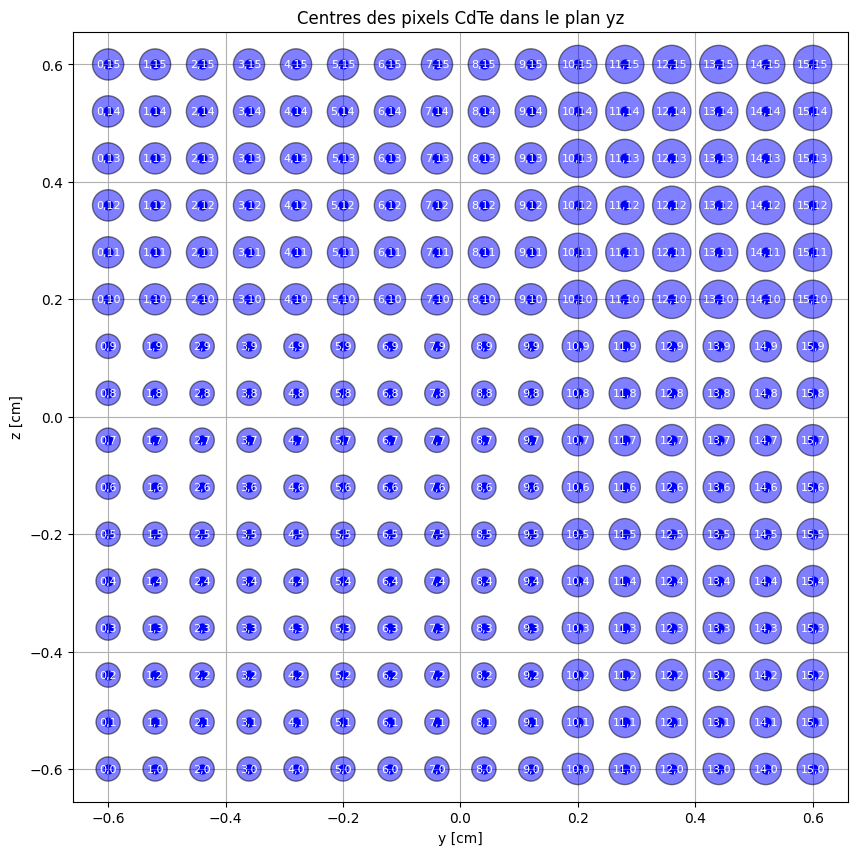

In [67]:
import matplotlib.pyplot as plt

# Getting 
y_coords = centers[:, 1]
z_coords = centers[:, 2]

# Taille de la matrice
n_y = 8
n_z = 16

plt.figure(figsize=(10, 10))
plt.scatter(y_coords, z_coords, c='blue', s=40)

# Marquage optionnel des indices (i, j)
for idx, (y, z) in enumerate(zip(y_coords, z_coords)):
    i, j = indices[idx]
    plt.text(y, z, f"{i},{j}", fontsize=8, ha='center', va='center', color='white', bbox=dict(boxstyle="circle", facecolor="blue", alpha=0.5))

plt.xlabel("y [cm]")
plt.ylabel("z [cm]")
plt.title("Centres des pixels CdTe dans le plan yz")
plt.grid(True)
plt.axis('equal')
plt.show()


In [68]:
print(f"Nombre de pixels créés : {len(pixel_cells)}")


Nombre de pixels créés : 256


In [69]:
pixel_cells

[Cell
 	ID             =	1328
 	Name           =	
 	Fill           =	Material 5
 	Region         =	(5300 -5301 5306 -5307 5308 -5309)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 Cell
 	ID             =	1329
 	Name           =	
 	Fill           =	Material 5
 	Region         =	(5300 -5301 5310 -5311 5312 -5313)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 Cell
 	ID             =	1330
 	Name           =	
 	Fill           =	Material 5
 	Region         =	(5300 -5301 5314 -5315 5316 -5317)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 Cell
 	ID             =	1331
 	Name           =	
 	Fill           =	Material 5
 	Region         =	(5300 -5301 5318 -5319 5320 -5321)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 Cell
 	ID             =	1332
 	Name           =	
 	Fill           =	Materia

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 27
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:    4    4
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 27: plot_openmc_xy.png...


/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/pre_processing/pre_processing.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


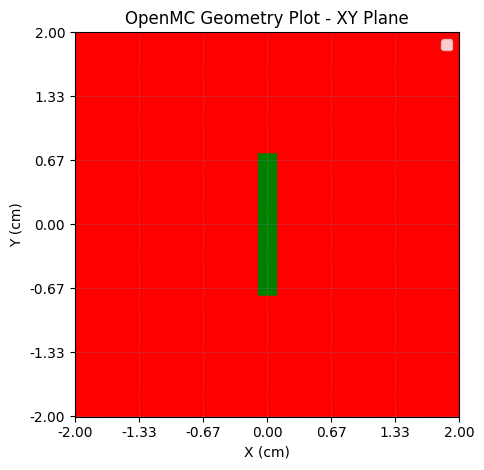

In [70]:
plot_geometry(materials = material, plane="xy", origin = (0.0, 0.0, 0), width=4, height=4, color_by="material")

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 28
Plot file: plot_openmc_xz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:    4    4
Coloring: Materials
Basis: XZ
Pixels: 600 600

 Processing plot 28: plot_openmc_xz.png...


/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/pre_processing/pre_processing.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


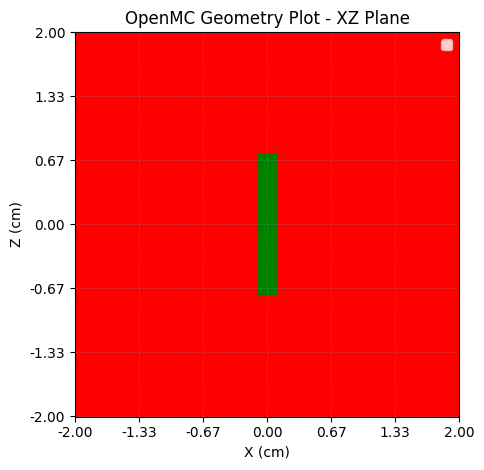

In [71]:
plot_geometry(materials=material, plane="xz", width=4, height=4, color_by="material")

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 29
Plot file: plot_openmc_yz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:    4    4
Coloring: Materials
Basis: YZ
Pixels: 600 600

 Processing plot 29: plot_openmc_yz.png...


/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/pre_processing/pre_processing.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


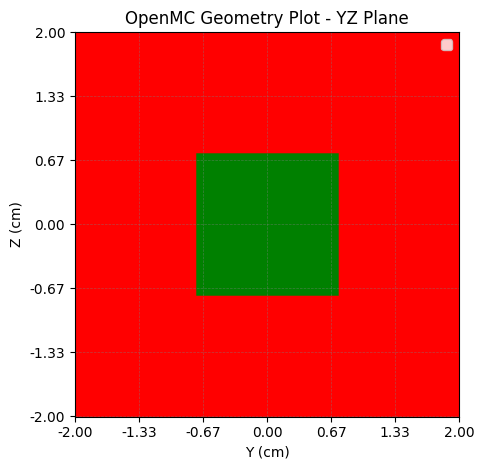

In [72]:
plot_geometry(materials=material, plane="yz", width=4, height=4, color_by="material")